# 레이블 부족문제 다루기

## 모듈 설치 및 import

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

# !pip install -U ipywidgets==7.7.1

Mounted at /content/drive/


In [2]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 526 (delta 143), reused 135 (delta 126), pack-reused 353
Receiving objects: 100% (526/526), 28.62 MiB | 16.69 MiB/s, done.
Resolving deltas: 100% (250/250), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# 9.1 Make github Issue Tagger

### 데이터 준비하기

In [4]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"dataframe size : {df_issues.shape}")

dataframe size : (9930, 26)


In [5]:
df_issues.columns

Index(['url', 'repository_url', 'labels_url', 'comments_url', 'events_url',
       'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels',
       'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments',
       'created_at', 'updated_at', 'closed_at', 'author_association',
       'active_lock_reason', 'body', 'performed_via_github_app',
       'pull_request'],
      dtype='object')

In [6]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [7]:
df_issues["labels"] = (df_issues["labels"]
                       .apply(lambda x : [meta["name"] for meta in x]))
df_issues["labels"].head()

0             []
1             []
2    [DeepSpeed]
3             []
4             []
Name: labels, dtype: object

In [8]:
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


In [9]:
 df_counts = df_issues["labels"].explode().value_counts()
 print(f"labels count: {len(df_counts)}")
 df_counts.to_frame().T

labels count: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage,Core: Pipeline,Feature request,...,lightning,Ex: Multiple Choice,rag,gpt2,work in progress,wandb,fairscale,Horizontal Model Parallel,fp16,Replication
count,2284,649,106,98,64,52,50,46,42,41,...,2,2,2,2,1,1,1,1,1,1


In [10]:
label_map = {
    "Core: Tokenization": "tokenization",
    "New model": "new model",
    "Core: Modeling": "model training",
    "Usage": "usage",
    "Core: Pipeline": "pipeline",
    "TensorFlow": "tensorflow or tf",
    "PyTorch": "pytorch",
    "Examples": "examples",
    "Documentation": "documentation"
}

In [11]:
def filter_labels(x):
  return [label_map[label] for label in x if label in label_map]
df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [12]:
df_counts = df_issues["labels"].explode().value_counts()

In [13]:
df_counts.to_frame().T

labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


In [14]:
df_issues["split"] = 'unlabeled'
mask = df_issues["labels"].apply(lambda x : len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [15]:
for columns in ["title", "body", "labels"]:
  print(f"{columns} : {df_issues[columns].iloc[26][:500]}\n")

title : Add new CANINE model

body : # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels : ['new model']



In [16]:
df_issues["text"] = (df_issues
                     .apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

In [17]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"drop_duplicates : {(len_before - len(df_issues))/len_before:.2%}")

drop_duplicates : 1.88%


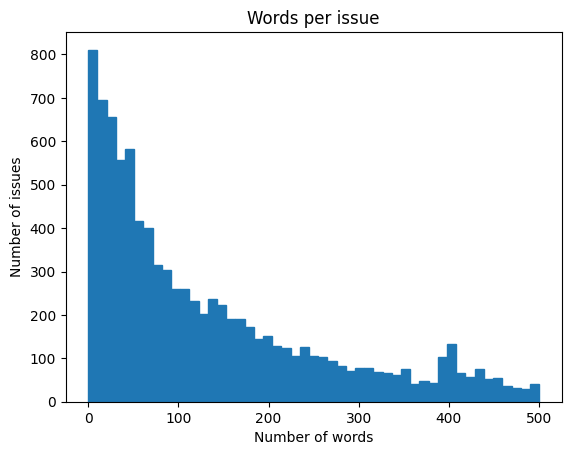

In [18]:
import numpy as np
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len).hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

### make train dataset

In [19]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit([all_labels])
mlb.transform([["tokenization", "new_model"], ["pytorch"]])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['new_model'] will be ignored
  warnings.warn(


array([[0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [20]:
all_labels

['tokenization',
 'new model',
 'model training',
 'usage',
 'pipeline',
 'tensorflow or tf',
 'pytorch',
 'examples',
 'documentation']

In [21]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=.5):
  ind = np.expand_dims(np.arange(len(df)), axis=1)
  labels = mlb.transform(df["labels"])
  ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, test_size)
  return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]

In [22]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=.5)
df_valid, df_test = balanced_split(df_tmp, test_size=.5)
# train : valid ; test = 2 : 1 : 1

In [23]:
df_train.head()

,text,labels
26,Add new CANINE model\n\n# 🌟 New model addition...,[new model]
107,Please implement DUMA: Reading Comprehension w...,[new model]
264,Can DeepSpeed ZeRO-3 be applied for training? ...,[new model]
484,XLSR-53\n\n# 🚀 Feature request\r\n\r\nIs it po...,[new model]
566,[examples] should all examples support the pre...,[examples]


In [24]:
df_valid.head()

,text,labels
439,Implementing efficient self attention in T5\n\...,[new model]
850,Uploaded a new model but is not found on the h...,[new model]
879,[example scripts] inconsistency around eval vs...,[examples]
939,PruneTrain: Fast Neural Network Training by Dy...,[new model]
1095,[Good first issue] DistilBERT PyTorch Integrat...,[pytorch]


In [25]:
df_test.head()

,text,labels
207,Add GPT-Neo\n\n# 🌟 New model addition\r\n\r\nP...,[new model]
500,Added max_sample_ arguments\n\n# What does thi...,[examples]
682,Knowledge Retrieval missing from BlenderBot Im...,[new model]
1039,[License info] Longformer SQuAD finetuned mode...,[new model]
1087,[Good first issue] MPNet TensorFlow Integratio...,[tensorflow or tf]


In [26]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))
})

In [27]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['text', 'labels'],
        num_rows: 9303
    })
})

In [84]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

In [85]:
for i, k in enumerate(train_samples):
  indices_pool, labels, new_slice, _ = iterative_train_test_split(
      indices_pool, labels, (k-last_k)/len(labels)
  )
  last_k = k
  if i == 0: train_slices.append(new_slice)
  else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

In [86]:
# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [31]:
print("target split size:")
print(train_samples)
print("real split size:")
print([len(x) for x in train_slices])

target split size:
[8, 16, 32, 64, 128, 223]
real split size:
[10, 19, 36, 68, 134, 223]


# 9.2 나이브 베이즈 모델 만들기
- 기준 모델을 구축 함으로써 정량적인 성능비교를 가능케함.
- 기준 모델은 복잡한 모델의 성능을 검증하는 용도로 사용할 수 있음.
- logistic-regression, tf-idf, 등의 간단한 모델을 활용함으로써 성능을 검증할 수 있음.

In [32]:
def prepare_labels(batch):
  batch["label_ids"] = mlb.transform(batch["labels"])
  return batch

ds = ds.map(prepare_labels, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [69]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [70]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
  ds_train_sample = ds["train"].select(train_slice)
  y_train = np.array(ds_train_sample["label_ids"])
  y_test = np.array(ds["test"]["label_ids"])

  count_vect = CountVectorizer()
  X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
  X_test_counts = count_vect.transform(ds["test"]["text"])

  classifier = BinaryRelevance(classifier=MultinomialNB())
  classifier.fit(X_train_counts, y_train)
  y_pred_test = classifier.predict(X_test_counts)
  clf_report = classification_report(
      y_test, y_pred_test, target_names=mlb.classes_, zero_division=0, output_dict=True
  )
  macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
  micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [35]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

  for run in micro_scores.keys():
    if run == current_model:
      ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
      ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
    else:
      ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
      ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")
  ax0.set_title("Micro F1-score")
  ax1.set_title("Macro F1-score")
  ax0.set_ylabel("Test set F1 score")
  ax0.legend(loc="lower right")

  for ax in [ax0, ax1]:
    ax.set_xlabel("Number of training samples")
    ax.set_xscale("log")
    ax.set_xticks(sample_sizes)
    ax.set_xticklabels(sample_sizes)
    ax.minorticks_off()
  plt.tight_layout()
  plt.show()

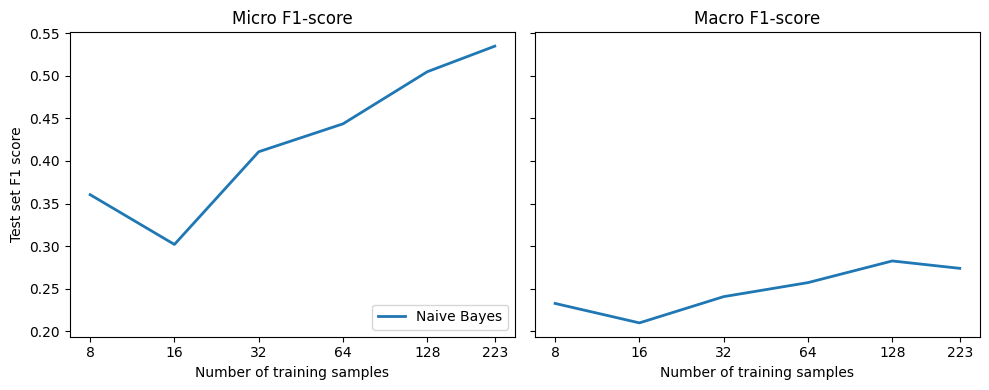

In [36]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

# 9.3 레이블링된 데이터가 없는경우

- This section was about the topic `[MASK]`. -> `[MASK]`를 예측함으로써 주제를 추론해냄.

In [37]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [48]:
movie_desc = "The main characters of the movie madacascar are a lion, a zebra, a giraffe, and a hippo."
prompt = " The movie is about [MASK]."
target_string = movie_desc + prompt

print(f"target_string -> {target_string}")

output = pipe(target_string, targets=["animals", "cars"])
print(output)
for element in output:
  print(f"token {element['token_str']}:\t{element['score']:.3f}%")

target_string -> The main characters of the movie madacascar are a lion, a zebra, a giraffe, and a hippo. The movie is about [MASK].
[{'score': 0.10329339653253555, 'token': 4176, 'token_str': 'animals', 'sequence': 'the main characters of the movie madacascar are a lion, a zebra, a giraffe, and a hippo. the movie is about animals.'}, {'score': 0.0007419314351864159, 'token': 3765, 'token_str': 'cars', 'sequence': 'the main characters of the movie madacascar are a lion, a zebra, a giraffe, and a hippo. the movie is about cars.'}]
token animals:	0.103%
token cars:	0.001%


In [50]:
movie_desc = "In the movie transformers aliens can morph into a wide range of vehicles."
prompt = " The movie is about [MASK]."
target_string = movie_desc + prompt

print(f"target_string -> {target_string}")

output = pipe(target_string, targets=["animals", "cars"])
print(output)
for element in output:
  print(f"token {element['token_str']}:\t{element['score']:.3f}%")

target_string -> In the movie transformers aliens can morph into a wide range of vehicles. The movie is about [MASK].
[{'score': 0.138701930642128, 'token': 3765, 'token_str': 'cars', 'sequence': 'in the movie transformers aliens can morph into a wide range of vehicles. the movie is about cars.'}, {'score': 0.005620069336146116, 'token': 4176, 'token_str': 'animals', 'sequence': 'in the movie transformers aliens can morph into a wide range of vehicles. the movie is about animals.'}]
token cars:	0.139%
token animals:	0.006%


### zero-shot-text-entailment

In [51]:
from transformers import pipeline

pipe = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [53]:
sample = ds["train"][0]
print(f"label: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\n 예측:")

for label, score in zip(output["labels"], output["scores"]):
  print(f"{label}, {score:.2f}")

label: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

 예측:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


- domain이 coding에 관한 것이기 때문에 제로샷 분류의 정확도가 떨어짐.
- MLNI Dataset의 원래 데이터 분포와 매우 다르다는 점을 감안해야함.

In [55]:
def zero_shot_pipeline(example):
  output = pipe(example["text"], all_labels, multi_label=True)
  example["predicted_labels"] = output["labels"]
  example["scores"] = output["scores"]
  return example

In [56]:
ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

  0%|          | 0/106 [00:00<?, ?ex/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:976: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


#### Multi Label Allcotaion Rules
- threshold 값을 넘은 label의 선택
- 점수가 높은 순으로 k개의 label을 선택

In [57]:
def get_preds(example, threshold=None, topk=None):
  preds = []
  if threshold:
    for label, score in zip(example["predicted_labels"], example["scores"]):
      if score >= threshold:
        preds.append(label)
  elif topk:
    for i in range(topk):
      preds.append(example["predicted_labels"][i])
  else:
    raise ValueError("threshold or topk must be specified")
  return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

In [58]:
def get_clf_report(ds):
  y_true = np.array(ds["label_ids"])
  y_pred = np.array(ds["pred_label_ids"])
  return classification_report(
      y_true, y_pred,
      target_names=mlb.classes_,
      zero_division=0, output_dict=True
  )

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

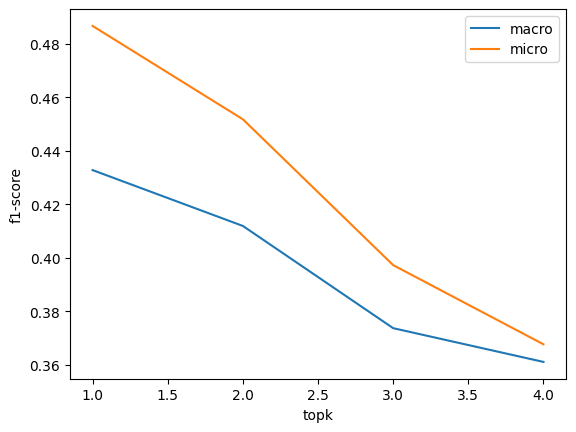

In [59]:
macros, micros =[], []
topks = [1, 2, 3, 4]
for topk in topks:
  ds_zero_shot = ds_zero_shot.map(get_preds, batched=False,
                                  fn_kwargs={"topk": topk})
  clf_report = get_clf_report(ds_zero_shot)
  macros.append(clf_report["macro avg"]["f1-score"])
  micros.append(clf_report["micro avg"]["f1-score"])

plt.plot(topks, macros, label="macro")
plt.plot(topks, micros, label="micro")
plt.xlabel("topk")
plt.ylabel("f1-score")
plt.legend(loc="best")
plt.show()

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

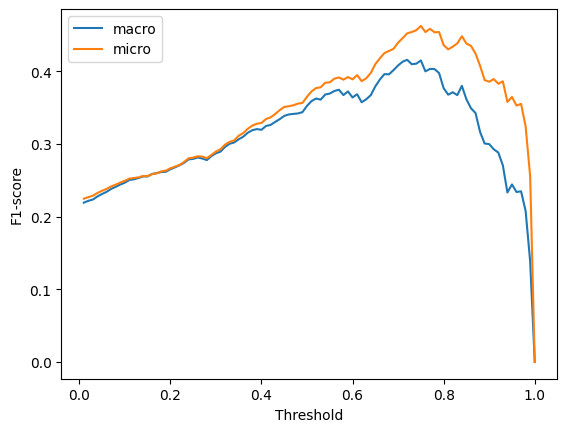

In [61]:
macros, micros =[], []
thresholds = np.linspace(.01, 1, 100)
for threshold in thresholds:
  ds_zero_shot = ds_zero_shot.map(get_preds,
                                  fn_kwargs={"threshold": threshold})
  clf_report = get_clf_report(ds_zero_shot)
  macros.append(clf_report["macro avg"]["f1-score"])
  micros.append(clf_report["micro avg"]["f1-score"])

plt.plot(thresholds, macros, label="macro")
plt.plot(thresholds, micros, label="micro")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

In [64]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f"best threshold(micro): {best_t}, F1: {best_micro:.2f}")
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f"best threshold(macro): {best_t}, F1: {best_macro:.2f}")

best threshold(micro): 0.75, F1: 0.46
best threshold(macro): 0.72, F1: 0.42


In [ ]:
ds_zero_shot = ds["test"].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds,
                                fn_kwargs={"topk": 1})


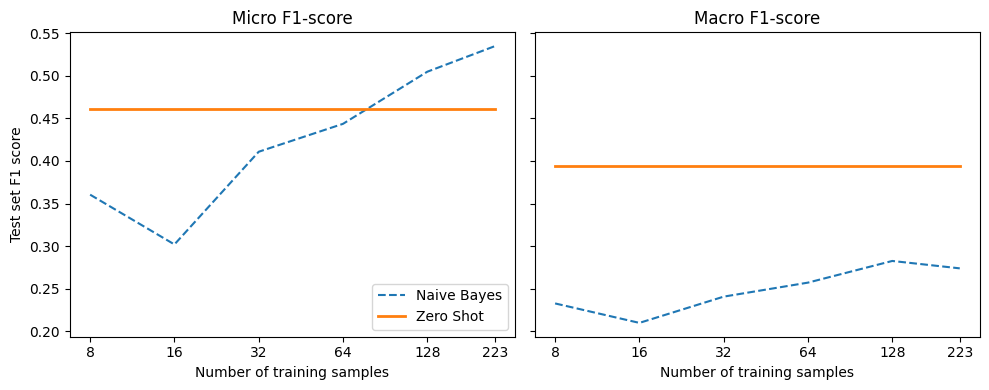

In [71]:
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
  macro_scores["Zero Shot"].append(clf_report["macro avg"]["f1-score"])
  micro_scores["Zero Shot"].append(clf_report["micro avg"]["f1-score"])
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

#### Zero-Shot이 뛰어난 이유!

- labeling된 sample이 50개보다 적으면 제로샷의 성능이 더 뛰어남.
- 샘플이 50개 이상이더라고 macro-f1을 고려할 때 제로샷 파이프라인이 나음.

# 9.4 레이블링된 데이터가 적은 경우

- Data Augmentation -> back_translation/token_perturbations

In [76]:
## 동의어 교체!
from transformers import set_seed
import nlpaug.augmenter.word as naw

set_seed(3)
aug = naw.ContextualWordEmbsAug(
    model_path="distilbert-base-uncased",
    device="cpu", action="substitute"
    )
text = "Transformers are the most popular toys"
print(f"original: {text}")
print(f"augmented: {aug.augment(text)}")

original: Transformers are the most popular toys
augmented: transformers'the most popular toys


In [88]:
def augment_text(batch, transformations_per_example=1):
  text_aug, label_ids = [], []
  for text, labels in zip(batch["text"], batch["label_ids"]):
    text_aug += [text]
    label_ids += [labels]
    for _ in range(transformations_per_example):
      text_aug += [aug.augment(text)]
      label_ids += [labels]
  return {"text":text_aug, "label_ids":label_ids}

In [ ]:
#hide
for train_slice in train_slices:
  # Get training slice and test data
  ds_train_sample = ds["train"].select(train_slice)
  # Flatten augmentations and align labels!
  ds_train_aug = (ds_train_sample.map(
      augment_text, batched=True, remove_columns=ds_train_sample.column_names)
                  .shuffle(seed=42))
  y_train = np.array(ds_train_aug["label_ids"])
  y_test = np.array(ds["test"]["label_ids"])
  # Use a simple count vectorizer to encode our texts as token counts
  count_vect = CountVectorizer()
  X_train_counts = count_vect.fit_transform(ds_train_aug["text"])
  X_test_counts = count_vect.transform(ds["test"]["text"])
  # Create and train our model!
  classifier = BinaryRelevance(classifier=MultinomialNB())
  classifier.fit(X_train_counts, y_train)
  # Generate predictions and evaluate
  y_pred_test = classifier.predict(X_test_counts)
  clf_report = classification_report(
      y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
      output_dict=True)
  # Store metrics
  macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
  micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

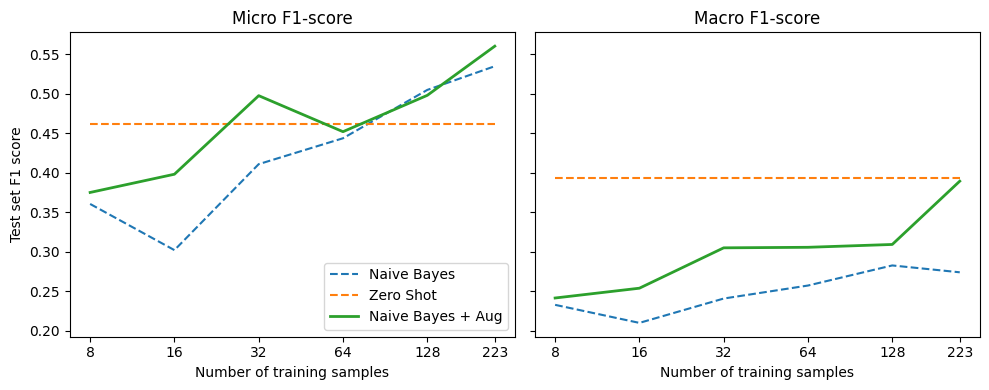

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")